In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torchtext
from torchtext.data import Iterator, BucketIterator
from torchvision import transforms, utils
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import f1_score as f1
import pandas as pd
import seaborn as sns

In [2]:
batch_size = 300
num_folds = 5

def split_text(text):
    return text.split(' ')

def prepare_sequences():
    tokenizer = split_text # the function above is the function we will be using to tokenize the text
    TEXT = torchtext.data.ReversibleField(sequential=True, tokenize=tokenizer, lower=True)
    LABEL = torchtext.data.Field(sequential=False, use_vocab=False) # sequential and use_vocab=False since no text (binary)
    QID = torchtext.data.Field(sequential=False, use_vocab=False)
    
    train_datafields = [('',None),("question_text", TEXT), ("target", LABEL)]
    fold_names = ['train_fold{}.csv'.format(i) for i in range(1,num_folds+1)]
    train_folds = []
    for fold in fold_names:
        train_folds.append(torchtext.data.TabularDataset( 
                # If we had a validation set as well, we would add an additional .splits(...)
                path=fold, # the root directory where the data lies
                format='csv',
                # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
                skip_header=True, 
                fields=train_datafields
                )
            )
    test_datafields = [('qid', QID),("question_text", TEXT)]
    test = torchtext.data.TabularDataset( 
                    path='test.csv',
                    format="csv",
                    skip_header=True,
                    fields=test_datafields
                    )
    return TEXT, LABEL, train_folds, test

TEXT, LABEL, train, test = prepare_sequences()
vec = torchtext.vocab.Vectors('master_v2.txt')
TEXT.build_vocab(*train,test, vectors=vec)

emb_vecs = TEXT.vocab.vectors
for i in range(len(emb_vecs)):
    if len(emb_vecs[i, : ].nonzero()) == 0:
        # std = 0.05 is based on the norm of average GloVE 100-dim word vectors
        torch.nn.init.normal_(emb_vecs[i], mean=0, std=0.05)
       
train_fold_loader = []
for fold in train:
    train_fold_loader.append(BucketIterator(
         fold, # we pass in the datasets we want the iterator to draw data from
         batch_size=batch_size,
         shuffle = True,
         sort_key=lambda x: len(x.question_text), # the BucketIterator needs to be told what function it should use to group the data.
         sort_within_batch=False, # sorting would add bias
         repeat=False 
        )
    )
test_loader = BucketIterator(
         test, # we pass in the datasets we want the iterator to draw data from
         batch_size=batch_size,
         sort_key=lambda x: len(x.question_text), # the BucketIterator needs to be told what function it should use to group the data.
         sort_within_batch=False, # sorting would add bias
         repeat=False 
        )

In [7]:
def validation(loader, test_set, predictions):
    accuracy = 0
    num_batches = 0
    act = np.array([])
    pred = np.array([])
    with torch.no_grad():
        for batch in loader:
            gpu = batch.question_text.to(device).long()
            preds = cnn(gpu)
            target = batch.target.numpy()
            preds = preds.cpu().detach().numpy()
            preds = preds >= 0.5
            preds = preds.flatten()
            total_correct = sum(target == preds)

            act = np.concatenate((act, target))
            pred = np.concatenate((pred, preds))

            accuracy += total_correct
            num_batches += 1
            torch.cuda.empty_cache()
            del gpu, target, preds
        
        count = 0
        for batch in test_set:
            qid = batch.qid
            question = batch.question_text.to(device).long()
            preds = cnn(question)
            preds = preds.cpu().detach().numpy()
            for idx, ID in enumerate(qid):
                predictions[ID.item()].append(preds[idx])
            torch.cuda.empty_cache()
            del qid, question, preds
            count+=1
    
    acc = accuracy / (num_batches * batch_size)
    print('Accuracy ->',acc)
    formula1 = f1(act, pred)
    print('f1 ->',formula1)
    tn,fp,fn,tp = cm(act, pred).ravel()
    print('True positives -> {}\nFalse positives -> {}\nTrue negatives -> {}\nFalse negatives -> {}\n'.format(tp,fp,tn,fn))
    return acc, formula1

def plot():
    plt.scatter([i for i in range(len(accuracy_fold))], f1_fold, label = 'F1 Training set')
    a = 0
    for r in f1_fold:
        a += r
    a /= len(f1_fold)
    plt.plot([i for i in range(len(accuracy_fold))], [a for i in range(len(accuracy_fold))], label = 'Avg fold f1 = {0:.3f}'.format(float(a)))
    plt.legend()
    plt.title('5 Fold Cross-validation F1 score cnn')
    plt.xlabel('Fold held out')
    plt.ylabel('F1 Score')
    plt.show()

def train_model(batch):
    cnn.zero_grad()
    optimizer.zero_grad()
    loss = 0
    
    gpu = batch.question_text.to(device).long()
    target = batch.target.to(device).to(device).float()

    predicted = cnn(gpu).view(-1)
    loss = criterion(predicted, target)
    loss.backward()
    optimizer.step()
    return loss.item()

In [4]:
class CNN(nn.Module): 
    def __init__(self,  #num channels
                 input_size,
                 num_channels,
                 kernel_size, #size of kernel
                 pool_size, #size of max pooling kernel
                 dropout
                 ):
        super(CNN, self).__init__()
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.num_channels = num_channels
        self.dropout = dropout
        self.max_features = 72
        
        self.emb = nn.Embedding(len(TEXT.vocab),input_size)
        self.emb.weight = nn.Parameter(TEXT.vocab.vectors)
        self.emb_dropout = nn.Dropout2d(dropout)
        
        self.conv = nn.Conv1d(self.max_features, 
                              self.num_channels,
                              self.kernel_size)
        
        self.batch_norm = nn.BatchNorm1d(self.num_channels)
        self.pool = nn.MaxPool1d(pool_size)
        self.relu = nn.LeakyReLU()
        
        self.output_size = (input_size - int(self.kernel_size/2)*2)/self.pool_size
        self.output_size = int(self.output_size*self.num_channels)
        self.layer = nn.Linear(self.output_size,1)
        self.sig = nn.Sigmoid()
    
    def forward(self, inpt):
        #bid lstm layer
        inpt = self.emb(inpt)
        inpt = self.emb_dropout(inpt)
        batch_size = inpt.shape[1]
        inpt = inpt.permute(1,0,2)
        #1D convolutional layer
        inpt = self.conv(inpt)
        inpt = self.relu(inpt)
        inpt = self.batch_norm(inpt)
        inpt = inpt.view(batch_size,-1)
        temp = inpt.size()[1]
        inpt = inpt.view(batch_size, 1,temp)
        inpt = self.pool(inpt)
        inpt = inpt.view(batch_size, -1)
        inpt = self.layer(inpt)
        inpt = self.sig(inpt)
        return inpt

  0%|          | 0/5 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++
Fold -> 0
	Epoch 1/5	AVG loss: 0.13199387719677216	Total loss:459.8666681535542
	Epoch 2/5	AVG loss: 0.10776599828821065	Total loss:375.4567380361259
	Epoch 3/5	AVG loss: 0.09214446499695665	Total loss:321.031316049397
	Epoch 4/5	AVG loss: 0.07345527605272308	Total loss:255.9181817676872
	Epoch 5/5	AVG loss: 0.055731657234605415	Total loss:194.16909380536526
Accuracy -> 0.9524378109452736
f1 -> 0.5819400257226021


 20%|██        | 1/5 [19:45<1:19:02, 1185.55s/it]

True positives -> 8597
False positives -> 4787
True negatives -> 240275
False negatives -> 7565

++++++++++++++++++++++++++++++++++++++++
Fold -> 1
	Epoch 1/5	AVG loss: 0.13278832955202505	Total loss:462.63454015925527
	Epoch 2/5	AVG loss: 0.10784258338570356	Total loss:375.7235605157912
	Epoch 3/5	AVG loss: 0.09163710011338257	Total loss:319.2636567950249
	Epoch 4/5	AVG loss: 0.07297503395887128	Total loss:254.24501831270754
	Epoch 5/5	AVG loss: 0.054549207150653846	Total loss:190.049437712878
Accuracy -> 0.9513777267508611
f1 -> 0.48039498045669615


 40%|████      | 2/5 [40:23<1:00:03, 1201.27s/it]

True positives -> 5838
False positives -> 2305
True negatives -> 242757
False negatives -> 10324

++++++++++++++++++++++++++++++++++++++++
Fold -> 2
	Epoch 1/5	AVG loss: 0.13308769376706825	Total loss:463.67752508446574
	Epoch 2/5	AVG loss: 0.10819509566732684	Total loss:376.9517133049667
	Epoch 3/5	AVG loss: 0.09249280714542187	Total loss:322.2449400946498
	Epoch 4/5	AVG loss: 0.07357662798672161	Total loss:256.3409719057381
	Epoch 5/5	AVG loss: 0.055171810971342036	Total loss:192.21858942415565
Accuracy -> 0.9528434749330271
f1 -> 0.5684685319613785


 60%|██████    | 3/5 [1:00:08<39:52, 1196.26s/it]

True positives -> 8066
False positives -> 4150
True negatives -> 240912
False negatives -> 8096

++++++++++++++++++++++++++++++++++++++++
Fold -> 3
	Epoch 1/5	AVG loss: 0.13212180942570712	Total loss:460.3123840391636
	Epoch 2/5	AVG loss: 0.10727121557155037	Total loss:373.73291505128145
	Epoch 3/5	AVG loss: 0.09146693496228155	Total loss:318.6708014085889
	Epoch 4/5	AVG loss: 0.07248094917010905	Total loss:252.52362690865993
	Epoch 5/5	AVG loss: 0.05440573110116857	Total loss:189.5495671564713
Accuracy -> 0.9520665901262916
f1 -> 0.5727425610049078


 80%|████████  | 4/5 [1:20:46<20:08, 1208.91s/it]

True positives -> 8344
False positives -> 4631
True negatives -> 240431
False negatives -> 7818

++++++++++++++++++++++++++++++++++++++++
Fold -> 4
	Epoch 1/5	AVG loss: 0.13368186078875846	Total loss:465.7476029880345
	Epoch 2/5	AVG loss: 0.10757072605235432	Total loss:374.77640956640244
	Epoch 3/5	AVG loss: 0.09177008781038935	Total loss:319.7269859313965
	Epoch 4/5	AVG loss: 0.07294607466946428	Total loss:254.14412414841354
	Epoch 5/5	AVG loss: 0.05400212505489083	Total loss:188.14340369123966
Accuracy -> 0.9522081898201301
f1 -> 0.5196222617849678


100%|██████████| 5/5 [1:41:25<00:00, 1217.96s/it]

True positives -> 6713
False positives -> 2963
True negatives -> 242099
False negatives -> 9449



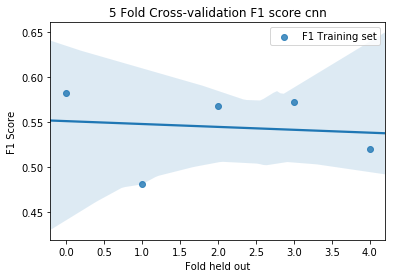

In [5]:
verbose = 100

#Model parameters
input_size = 300
num_channels = 72
kernel_size = 5
pool_size = 100
dropout = 0.1

epoch = 5

#Evaluation metrics for model
accuracy_fold = []
f1_fold = []
avg_error = []
preds = {i:[] for i in range(375806)}

ngpu = 1
device = torch.device("cuda: 0" if(torch.cuda.is_available() and ngpu >= 1) else "cpu")

from tqdm import tqdm
for i in tqdm(range(num_folds)): 
    try:
        cnn = CNN(input_size, num_channels, kernel_size, pool_size, dropout).cuda()
    except:
        cnn = CNN(input_size, num_channels, kernel_size, pool_size, dropout).cuda()

    optimizer = optim.Adam(cnn.parameters())
    criterion = nn.BCELoss()
    
    train_folds = []
    
    for j in range(num_folds): 
        if j != i:
            train_folds.append(train_fold_loader[j])
        else: 
            val_fold = train_fold_loader[j]
    
    cnn.train()
    print('++++++++++++++++++++++++++++++++++++++++')
    print('Fold -> {}'.format(i))
    for e in range(1, epoch+1):
        total_error = 0
        num = 0
        np.random.shuffle(train_folds)
        for fold in train_folds:
            for batch in fold:
                loss = train_model(batch)
                total_error += loss
                torch.cuda.empty_cache()
            num += 1
            torch.cuda.empty_cache()
        avg_loss = total_error/(len(train_folds)*len(train_folds[0]))
        print('\tEpoch {}/5\tAVG loss: {}\tTotal loss:{}'.format(e, avg_loss, total_error))
        torch.cuda.empty_cache()
        avg_error.append(avg_loss)
    cnn.eval()
    acc, f = validation(val_fold, test_loader, preds)
    accuracy_fold.append(acc)
    f1_fold.append(f)
    torch.cuda.empty_cache()
plot()

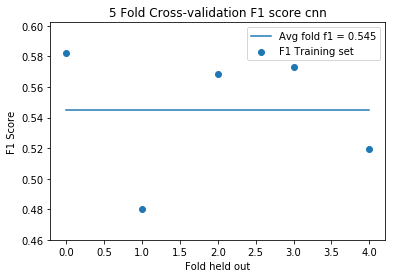

In [8]:
plot()

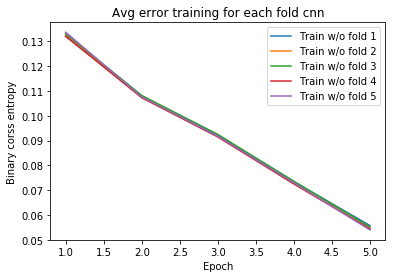

In [6]:
start = 0
end = 5
for i in range(5):
    plt.plot([i for i in range(1,6)], avg_error[start:end], label = 'Train w/o fold {}'.format(i+1))
    start = end
    end += 5
plt.title('Avg error training for each fold cnn')
plt.legend()
plt.ylabel('Binary corss entropy')
plt.xlabel('Epoch')
plt.show()

In [9]:
with open('result_cnn.txt', mode = 'w') as f: 
    for key in preds.keys():
        f.write(str(key))
        for val in preds[key]:
            f.write(' {}'.format(str(val)))
        f.write('\n')

In [ ]:
predictions = {}
for key in preds.keys(): 
    threshold = 0.8
    temp = []
    for val in preds[key]:
        temp.append(val > threshold)
    temp = sum(temp)
    if temp > 2: 
        predictions[key] = 1
    else:
        predictions[key] = 0
predictions = sorted(predictions.items())

In [ ]:
predictions = [x[1] for x in predictions]
qid = pd.read_csv('qid.csv')
sub = {'qid':list(qid.qid), 'prediction':predictions}
submission_ = pd.DataFrame.from_dict(sub)

In [ ]:
actual = pd.read_csv('submission.csv')
flagged = submission_[submission_.prediction == 1]
act_flagged = actual[actual.prediction == 1]
found = 0
for i in act_flagged.index: 
    if submission_.prediction.iloc[i] == 1:
        found += 1
print(found)

In [ ]:
with open('preds.txt', mode = 'w') as f: 
    f.write('import pandas as pd \n')
    f.write('pred = [')
    count = 0
    written = 0
    #replace data -> pd dataframe
    for ind in submission_.index: 
        if count < 40:
            if submission_.prediction.iloc[ind]:
                f.write('{},'.format(1))
            else: 
                f.write('{},'.format(0))
            count += 1
            written += 1
        else: 
            f.write('\n')
            if submission_.prediction.iloc[ind]:
                f.write('{},'.format(1))
            else: 
                f.write('{},'.format(0))
            count = 0
            written += 1
    f.write(']\n')
    f.write('test = pd.read_csv(\'../input/test.csv\').qid\n')
    f.write('sub = {\'qid\':[], \'prediction\':[]}\n')

    f.write('for i in range(len(pred)):\n')
    f.write('\tsub[\'qid\'].append(test.iloc[i])\n')
    f.write('\tsub[\'prediction\'].append(pred[i])\n')
    f.write('sub = pd.DataFrame.from_dict(sub)\n')
    f.write('sub.to_csv(\'submission.csv\', index=False)')